In [1]:
import os
import sys
new_path = r'/home/maxim/dev/mzhn-team-sochi/price_tag_analyzer'
sys.path.append(new_path)

In [2]:
from ultralytics import YOLO
import cv2
import easyocr
from spellchecker import SpellChecker

MODEL_NAME = '/home/maxim/dev/mzhn-team-sochi/price_tag_analyzer/yolov8-price-tag-detection.pt'

In [3]:
model = YOLO(MODEL_NAME)
reader = easyocr.Reader(['ru', 'en'])
spellchecker = SpellChecker(language=['ru', 'en'])
# Повышаем приоритет известных слов (названий продуктов и единиц измерений) в словаре
current_dir =  '/home/maxim/dev/mzhn-team-sochi/price_tag_analyzer/price_tag_analyzer' # os.path.dirname(os.path.realpath(__file__))
csv_files = ['products.csv', 'unit_liquid.csv', 'unit_solid.csv']
for file_name in csv_files:
    with open(os.path.join(current_dir, 'parse_texts/data/', file_name), 'r') as f:
        for line in f:
            for phrase in line.strip().split(','):
                for word in phrase.split(' '):
                    spellchecker.word_frequency.add(word, sys.maxsize)

In [4]:
base_path = '/home/maxim/ultralytics/datasets/yolov8-price-tag-detection-dataset/images/val/'
files = os.listdir(base_path)

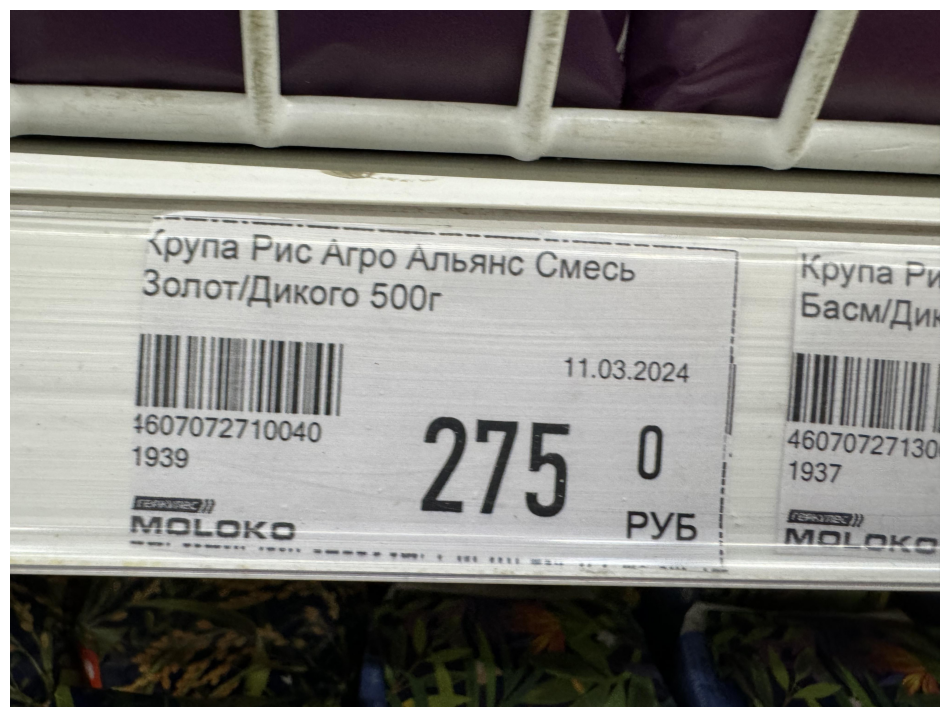

In [5]:
import supervision as sv

i = 1

file = files[i]

image = cv2.imread(os.path.join(base_path, file))

sv.plot_image(image)



0: 480x640 2 descriptions, 1 price_whole, 1 price_fraction, 169.2ms
Speed: 2.6ms preprocess, 169.2ms inference, 100.2ms postprocess per image at shape (1, 3, 480, 640)


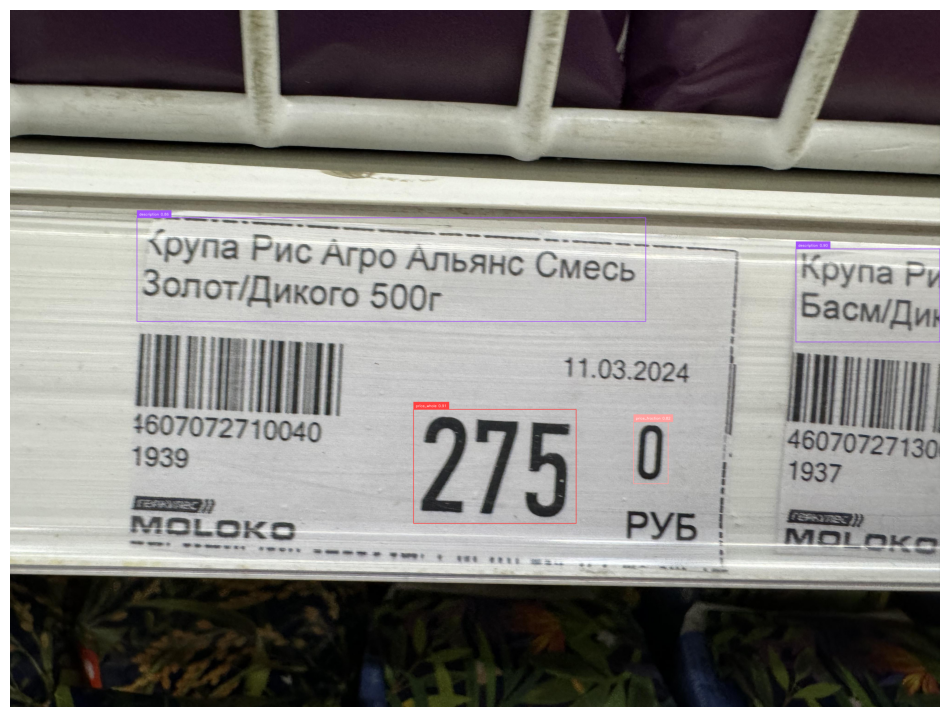

In [6]:
results = model(image)

detections = sv.Detections.from_ultralytics(results[0])

labels = [
    f"{model.names[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.LabelAnnotator()
annotated_frame = bounding_box_annotator.annotate(
    scene=image.copy(),
    detections=detections, labels=labels
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = bounding_box_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

sv.plot_image(image=annotated_frame)

In [7]:
from price_tag_analyzer.process import process, ProcessException

try: 
    imginfo = process(
        image,
        model,
        reader,
        spellchecker,
    )

    print(f'Product: {imginfo.product}')
    print(f'Price: {imginfo.price}')
except ProcessException as e:
    print('Erorr: ', e.json_dump())

2024-04-13 11:46:16.667 | DEBUG    | price_tag_analyzer.process:process:251 - YOLO: 0.17 sec
2024-04-13 11:46:17.245 | DEBUG    | price_tag_analyzer.process:process:282 - OCR: 0.58 sec
2024-04-13 11:46:19.640 | DEBUG    | price_tag_analyzer.process:process:295 - Spellcheck: 2.39 sec
2024-04-13 11:46:19.640 | DEBUG    | price_tag_analyzer.process:process:297 - Description: Хрупа Рис Агpо Альянс Смесь Золот/Дикого 50Ог
2024-04-13 11:46:19.641 | DEBUG    | price_tag_analyzer.process:process:298 - Fixed description: крупа рис его альянс смесь золот/дикого 500г
2024-04-13 11:46:19.646 | DEBUG    | price_tag_analyzer.process:process:310 - NER: 0.01 sec


Product: Рис
Price: 275.0
